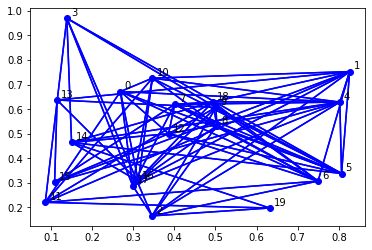

In [1]:
import numpy as np
import algos.graphdrawing as gd
      
V, adj_V = gd.gen_graph(num_verts=20, max_nbrs=10)
gd.draw(V, adj_V)

# Edge-Edge Repulsion (Lin & Yen, 2012)
Apply forces based on the angle formed by incident edges.

Angular resolution: 0.5736473545014067


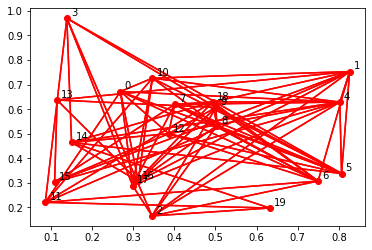

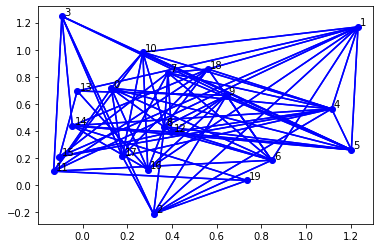

Angular resolution: 0.5860431588927861


In [2]:
import algos.lin_yen as ly
import algos.geometry as geo
import matplotlib.pyplot as plt
from importlib import reload

reload(ly)
gd.draw(V, adj_V, 'r')
print(f'Angular resolution: {geo.get_angular_res(V, adj_V)}')
W = ly.ee_repulsion(V, adj_V, C0=1, C1=0.01)
plt.show()

gd.draw(W, adj_V)
plt.show() 

print(f'Angular resolution: {geo.get_angular_res(W, adj_V)}')

# Force-directed edge-vertex repulsion

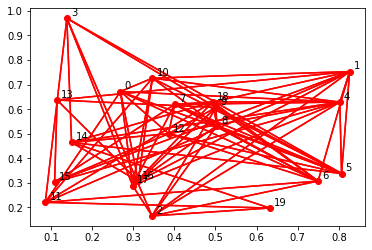

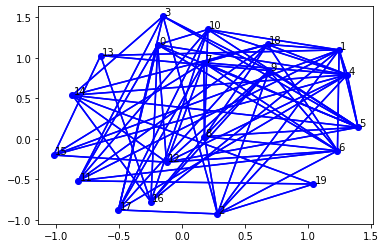

In [3]:
import numpy as np
import math
import algos.lin_yen as ly

      
gd.draw(V, adj_V, 'r')
plt.show()
W = ly.ev_repulsion(V, adj_V, N=10, C1=1, C2=1, C3=0.001)
gd.draw(W, adj_V)
plt.show()

# Vertex-vertex repulsion (Birchfield & Overbye, 2018)

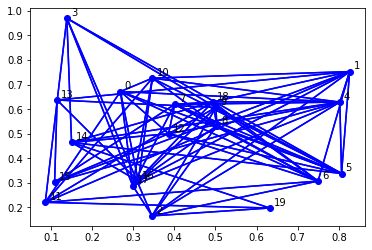

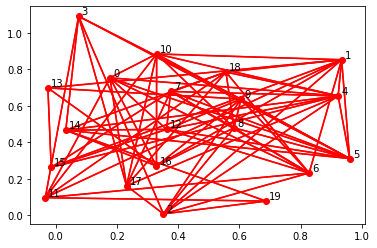

In [4]:
import algos.birchfield as bf
import algos
from importlib import reload

reload(algos.birchfield)
gd.draw(V, adj_V, 'b')
plt.show()
W = bf.force_directed(V, adj_V, N=10, C1=2, C2=0.1, C3=0.005)
gd.draw(W, adj_V, 'r')

# Line intersections

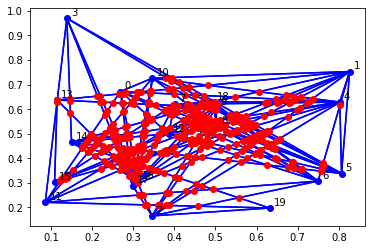

In [5]:
import matplotlib.pyplot as plt
from importlib import reload

ints = geo.get_intersects(V, adj_V)
gd.draw(V, adj_V, 'b')
C = np.array([c['intersection'] for c in ints])
plt.plot(C[:,0], C[:,1], 'ro')
plt.show()

# Used later for cross resolution maximization

# Algorithm for Cross Angular Resolution

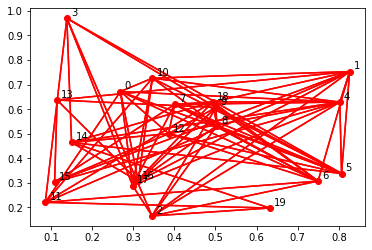

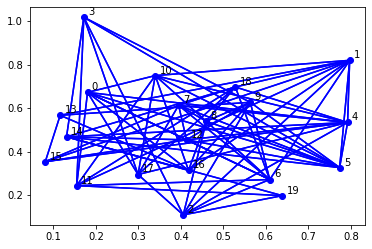

In [6]:
reload(ly)
W = ly.cross_repulsion(V, adj_V, N=15, C0=1, C1=0.001, C2=0.001)
gd.draw(V, adj_V, 'r')
plt.show()
gd.draw(W, adj_V)
plt.show()

# BIGANGLE

Original graph V


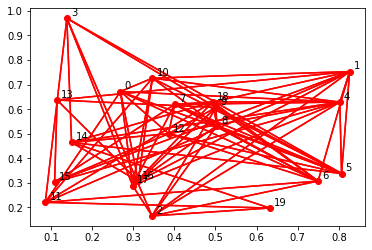

Big angle without forces to original positions
i = 0 tensor(178.4450, dtype=torch.float64, grad_fn=<SumBackward0>)
i = 1 tensor(173.7346, dtype=torch.float64, grad_fn=<SumBackward0>)
i = 2 tensor(168.4720, dtype=torch.float64, grad_fn=<SumBackward0>)
i = 3 tensor(153.5688, dtype=torch.float64, grad_fn=<SumBackward0>)
i = 4 tensor(161.8037, dtype=torch.float64, grad_fn=<SumBackward0>)
i = 5 tensor(165.1510, dtype=torch.float64, grad_fn=<SumBackward0>)
i = 6 tensor(150.9385, dtype=torch.float64, grad_fn=<SumBackward0>)
i = 7 tensor(132.9270, dtype=torch.float64, grad_fn=<SumBackward0>)
i = 8 tensor(127.1462, dtype=torch.float64, grad_fn=<SumBackward0>)
i = 9 tensor(150.5029, dtype=torch.float64, grad_fn=<SumBackward0>)
i = 10 tensor(137.2927, dtype=torch.float64, grad_fn=<SumBackward0>)
i = 11 tensor(147.3512, dtype=torch.float64, grad_fn=<SumBackward0>)
i = 12 tensor(120.6721, dtype=torch.float64, grad_fn=<SumBackward0>)
i = 13 tensor(119.7991, dtype=torch.float64, grad_fn=<SumBackward0

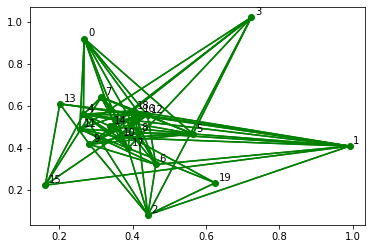

Big angle with forces to original positions
i = 0 tensor(178.4450, dtype=torch.float64, grad_fn=<SumBackward0>)
i = 1 tensor(173.7346, dtype=torch.float64, grad_fn=<SumBackward0>)
i = 2 tensor(173.7523, dtype=torch.float64, grad_fn=<SumBackward0>)
i = 3 tensor(179.5011, dtype=torch.float64, grad_fn=<SumBackward0>)
i = 4 tensor(185.7765, dtype=torch.float64, grad_fn=<SumBackward0>)
i = 5 tensor(154.1548, dtype=torch.float64, grad_fn=<SumBackward0>)
i = 6 tensor(188.8116, dtype=torch.float64, grad_fn=<SumBackward0>)
i = 7 tensor(167.0896, dtype=torch.float64, grad_fn=<SumBackward0>)
i = 8 tensor(164.7010, dtype=torch.float64, grad_fn=<SumBackward0>)
i = 9 tensor(158.7579, dtype=torch.float64, grad_fn=<SumBackward0>)
i = 10 tensor(158.4426, dtype=torch.float64, grad_fn=<SumBackward0>)
i = 11 tensor(173.2091, dtype=torch.float64, grad_fn=<SumBackward0>)
i = 12 tensor(172.4502, dtype=torch.float64, grad_fn=<SumBackward0>)
i = 13 tensor(162.6338, dtype=torch.float64, grad_fn=<SumBackward0>)


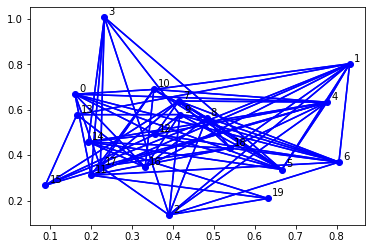

Combined


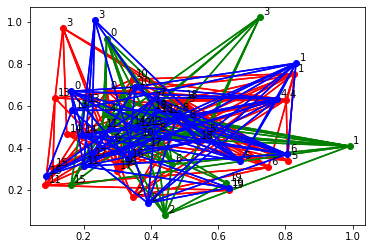

In [7]:
import algos.lin_yen as ly

reload(ly)
print('Original graph V')
gd.draw(V, adj_V, 'r')
plt.show()

print('Big angle without forces to original positions')
W1 = ly.bigangle(V, adj_V, N=15, C0=1, C1=0.01, C2=1, C3=0.001, F2V=False)
gd.draw(W1, adj_V, 'g')
plt.show()

print('Big angle with forces to original positions')
W2 = ly.bigangle(V, adj_V, N=15, C0=500, C1=0.01, C2=1, C3=0.001, F2V=True)
gd.draw(W2, adj_V, 'b')
plt.show()

print('Combined')
gd.draw(V, adj_V, 'r')
gd.draw(W1, adj_V, 'g')
gd.draw(W2, adj_V, 'b')
plt.show()

Big angle with forces to original positions
i = 0 tensor(178.4450, dtype=torch.float64, grad_fn=<SumBackward0>)
i = 1 tensor(176.6185, dtype=torch.float64, grad_fn=<SumBackward0>)
i = 2 tensor(169.0087, dtype=torch.float64, grad_fn=<SumBackward0>)
i = 3 tensor(169.7043, dtype=torch.float64, grad_fn=<SumBackward0>)
i = 4 tensor(168.3767, dtype=torch.float64, grad_fn=<SumBackward0>)
i = 5 tensor(168.6420, dtype=torch.float64, grad_fn=<SumBackward0>)
i = 6 tensor(168.4208, dtype=torch.float64, grad_fn=<SumBackward0>)
i = 7 tensor(172.6857, dtype=torch.float64, grad_fn=<SumBackward0>)
i = 8 tensor(173.3856, dtype=torch.float64, grad_fn=<SumBackward0>)
i = 9 tensor(169.7530, dtype=torch.float64, grad_fn=<SumBackward0>)
i = 10 tensor(169.3917, dtype=torch.float64, grad_fn=<SumBackward0>)
i = 11 tensor(170.4610, dtype=torch.float64, grad_fn=<SumBackward0>)
i = 12 tensor(166.7401, dtype=torch.float64, grad_fn=<SumBackward0>)
i = 13 tensor(169.2276, dtype=torch.float64, grad_fn=<SumBackward0>)


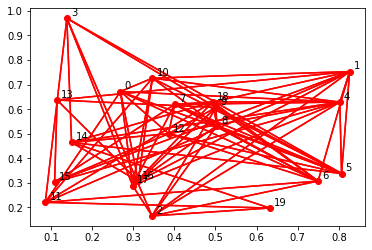

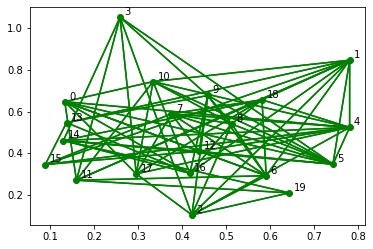

In [8]:
from importlib import reload

reload(ly)

print('Big angle with forces to original positions')
W2 = ly.bigangle(V, adj_V, N=25, C0=0, C1=0.001, C2=0, C3=0.001, F2V=False)
gd.draw(V, adj_V, 'r')
plt.show()
gd.draw(W2, adj_V, 'g')
plt.show()


Loss: 33.85; Progress: 100%|██████████| 50/50 [00:10<00:00,  4.98it/s]


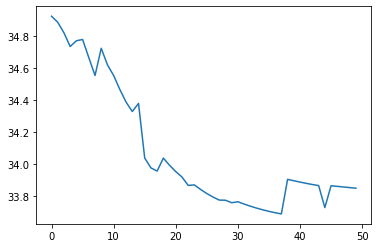

In [322]:
from algos.graphgd import *
from importlib import reload
import matplotlib.pyplot as plt

reload(algos.graphgd)

W, losses = train(V, adj_V, N=50)

plt.plot(losses)
plt.show()

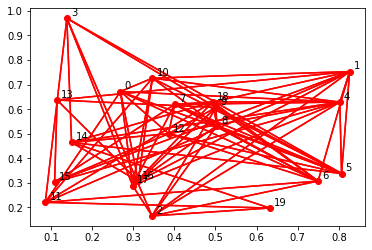

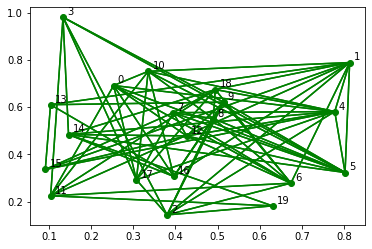

In [323]:
gd.draw(V, adj_V, 'r')
plt.show()
gd.draw(W.detach().numpy(), adj_V, 'g')
plt.show()

# Map dingetjes

In [9]:
import pandas as pd
import geopandas as gpd

# Haal de kaart met gemeentegrenzen op van PDOK
geodata_url = 'https://geodata.nationaalgeoregister.nl/cbsgebiedsindelingen/wfs?request=GetFeature&service=WFS&version=2.0.0&typeName=cbs_gemeente_2017_gegeneraliseerd&outputFormat=json'
gemeentegrenzen = gpd.read_file(geodata_url)

<AxesSubplot:>

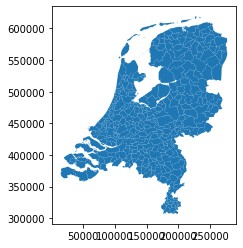

In [10]:
gemeentegrenzen.plot()

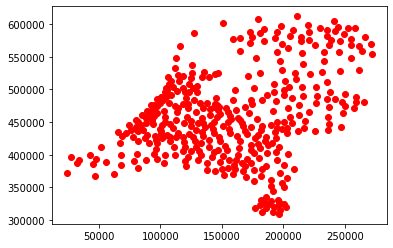

In [11]:
cents = [gem.centroid.xy for gem in gemeentegrenzen['geometry']]
cents = np.array(cents)
plt.plot(cents[:,0], cents[:,1], 'ro')
plt.show()

# Data from Json

# Displacement measure & simple visualization
Darker the 

Total sum of (squared) displacement: 0.09546592476783355


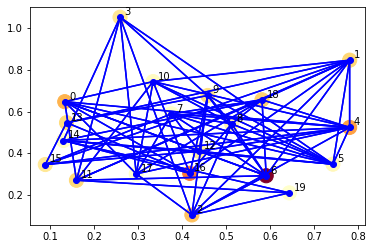

In [12]:
import algos.geometry as geo
from importlib import reload

reload(geo)
disps = geo.get_displacement(V, W)
print(f"Total sum of (squared) displacement: {sum(disps)}")
gd.draw(W2, adj_V, 'b')
plt.scatter(x=W2[:,0], y=W2[:,1], c=disps, s=200, cmap='YlOrRd')
plt.show()

In [13]:
import algos.geometry as geo
from numpy.linalg import norm

ints = geo.get_intersects(W2, adj_V)
L_cam = []
for it in ints:
  i = it['e1'][0]
  j = it['e1'][1]
  k = it['e2'][0]
  l = it['e2'][1]
  ij = W[i] - W[j]
  kl = W[k] - W[l]
  t = [ij, kl]
  b = np.dot(norm(ij), norm(kl))
  L_cam.append((t / b) ** 2)
print(L_cam)

[array([[0.40902707, 0.93248948],
       [2.98846773, 2.40629849]]), array([[0.57713185, 1.31573045],
       [4.74105529, 0.65371093]]), array([[0.41733093, 0.9514204 ],
       [3.79005721, 1.60470901]]), array([[0.34567411, 0.78805902],
       [0.33492263, 5.05984359]]), array([[0.56458676, 1.28713048],
       [0.16282016, 5.23194606]]), array([[1.00151301, 2.28322379],
       [0.02934073, 5.36542549]]), array([[5.07661331e-01, 1.15735334e+00],
       [2.55062931e-03, 5.39221559e+00]]), array([[0.68965626, 1.57226073],
       [5.34130989, 0.05345633]]), array([[0.5658084 , 1.28991554],
       [5.06938361, 0.32538261]]), array([[1.01391349, 2.31149409],
       [4.36462211, 1.03014411]]), array([[0.70379032, 1.6044832 ],
       [5.14564014, 0.24912608]]), array([[1.84172126, 4.19870912],
       [3.20919235, 2.18557387]]), array([[2.76065439, 6.2936694 ],
       [0.44518136, 4.94958486]]), array([[1.49575378, 3.40998127],
       [5.30001762, 0.0947486 ]]), array([[1.45964311, 3.32765711]

In [14]:
import algos.odf_vis as odf
from importlib import reload

reload(odf)
coords, adj_gem = odf.get_ww()

i = 0 tensor(513.3824, dtype=torch.float64, grad_fn=<SumBackward0>)


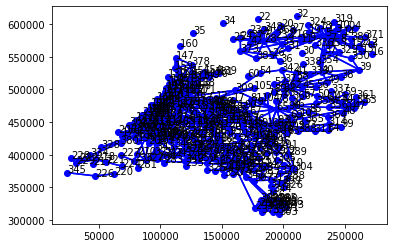

In [15]:
W = ly.bigangle(coords, adj_gem, N=1, C0=1, C1=0.01, C2=1, C3=1, F2V=True)

gd.draw(coords, adj_gem)
plt.show()

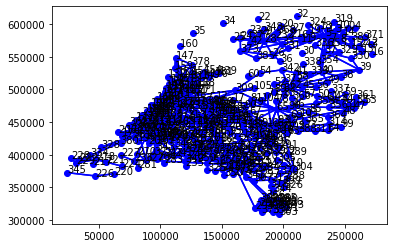

In [16]:
gd.draw(W, adj_gem)
plt.savefig('w.jpg')